In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import torch

from mlflux.predictor import FluxANNs
from mlflux.eval import open_case, evaluate, eval_bias, plot_pred, plot_res, plot_corr

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 3

In [2]:
datafile = '/scratch/jw8736/mlflux/data/Processed/psd_coare3p6_weight1_wave0.nc'
ds_psd = xr.load_dataset(datafile)

In [7]:
from tqdm import tqdm

''' Split data based on time interval.
    Interval tolerance in minutes. 2880 = 2 days.
    Note that this doesn't mean the resulting dt are uniform. 
    We've just split really large dt.
'''
def split_psd (psd, pcode, interval_tolerance=2880, latlon_tolerance=1):
    ds = psd.where(psd.pcode==pcode, drop=True) 
    split = []

    for i in tqdm(range(1,len(ds.time)-1)):
        dt_forward = (ds.time[i+1] - ds.time[i]).astype('float32')/6e10
        dt_backward = (ds.time[i] - ds.time[i-1]).astype('float32')/6e10    
        dlat_forward = ds.lat[i+1] - ds.lat[i]  
        dlon_forward = ds.lon[i+1] - ds.lon[i]

        if (dt_forward > interval_tolerance) & (dt_backward > 0): # Split stage that are seperated by more than 2 days
            split.append(i)
        elif (abs(dlat_forward) > latlon_tolerance): 
            split.append(i)
        elif (abs(dlon_forward) > latlon_tolerance): 
            split.append(i)
            
    return ds, split


''' Add a stage label to data set. '''
def stage_label(ds, split):
    stage = np.ones(ds.sizes['time'])
    print(len(split))
    
    for i in range(len(split)):
        if i == 0:
            stage[:(split[i]+1)] *= 0
        else:
            stage[(split[i-1]+1):(split[i]+1)] *= i   
    stage[(split[-1]+1):] *= len(split)
    
    ds['stage'] = ('time', stage)
    
    return ds

100%|██████████| 189/189 [00:00<00:00, 204.36it/s]


10
Lat [-53 -44]
Lon [142 151]


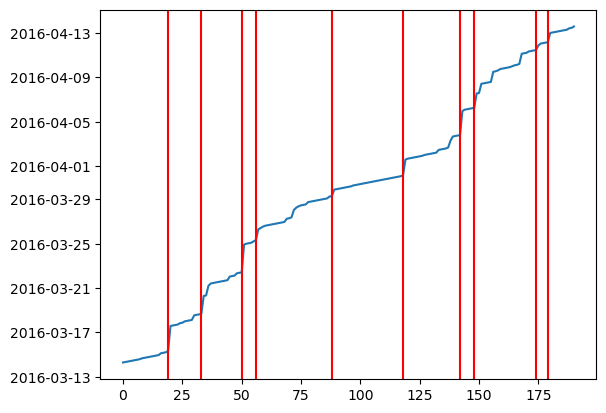

In [123]:
# Manually split and check each one
# Metz=77 Epic=69 WHOTS=87 STRATUS=83 NEAQS=78 HiWInGS=72 GasEx=71 DYNAMO=68 Calwater=67 Capricorn=73

pcode = 73

# We can use a small interval tolerance (say 1 day = 1440 mins) and then further filter based on duration
# Or we can use a larger interval
ds, split = split_psd (ds_psd, pcode, interval_tolerance=1440, latlon_tolerance=1)
if len(split) > 0:
    ds = stage_label(ds, split)
else:
    ds['stage'] = ds['U'] * 0

print('Lat [%.0f %.0f]' %(ds.lat.min(),ds.lat.max()))
print('Lon [%.0f %.0f]' %(ds.lon.min(),ds.lon.max()))
plt.plot(ds.time)
for index in split:
    plt.axvline(index, c='red')

-2.453861604588237
-2.2238902825550273
3.4311645523432674
-7.05131489729287


(-100.0, 100.0)

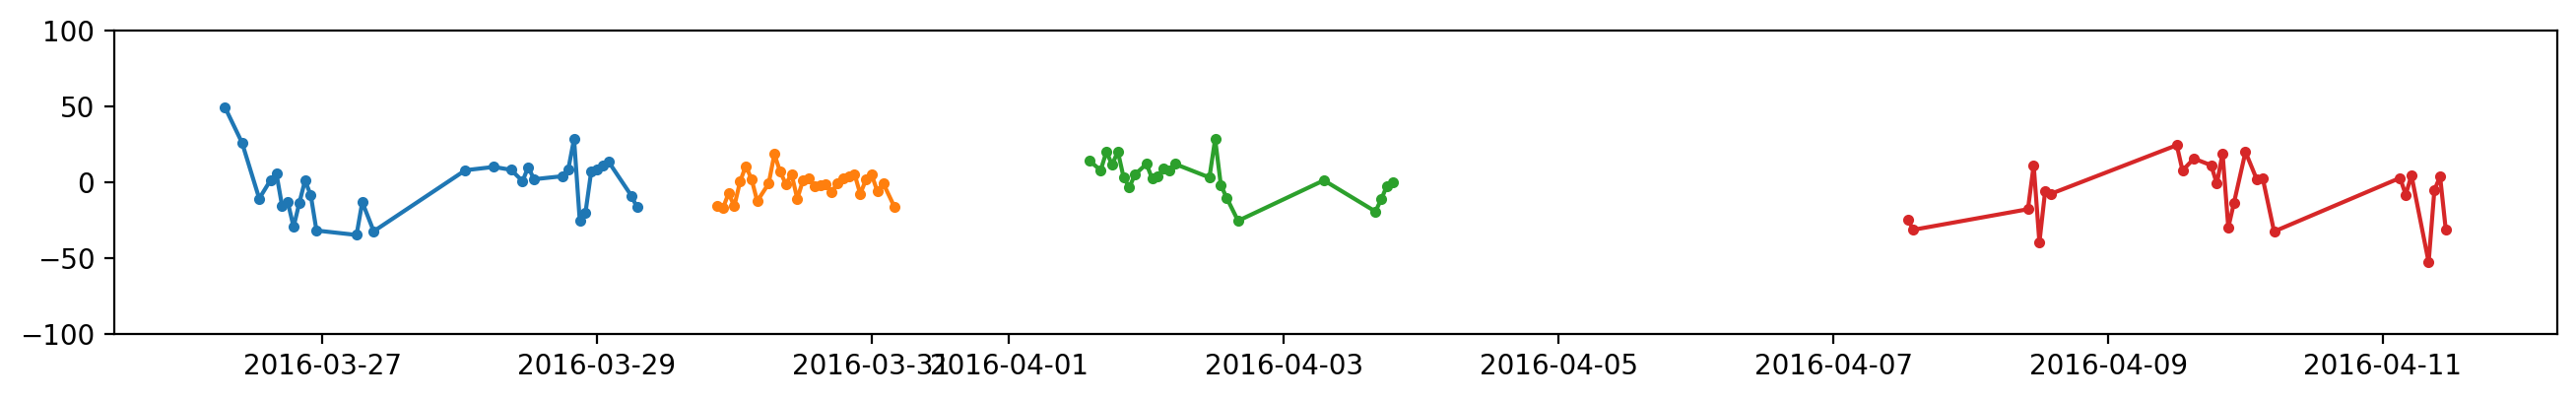

In [124]:
plt.figure(figsize=[16, 2], dpi=200)
pcode = 73
for s in range(0, int(ds.stage.max().values)+1):
    diff = ds.where((ds.pcode==pcode) & (ds.stage==s), drop=True).hlc - ds.where((ds.pcode==pcode) & (ds.stage==s), drop=True).hlb
    if len(diff.values) > 20:
        plt.plot(diff.time, diff.values, '.-')
        print(np.mean(diff.values))
plt.ylim([-100, 100])

10.832421302826138
13.938394864094194
7.68193262652271
5.639631564934193


(-100.0, 100.0)

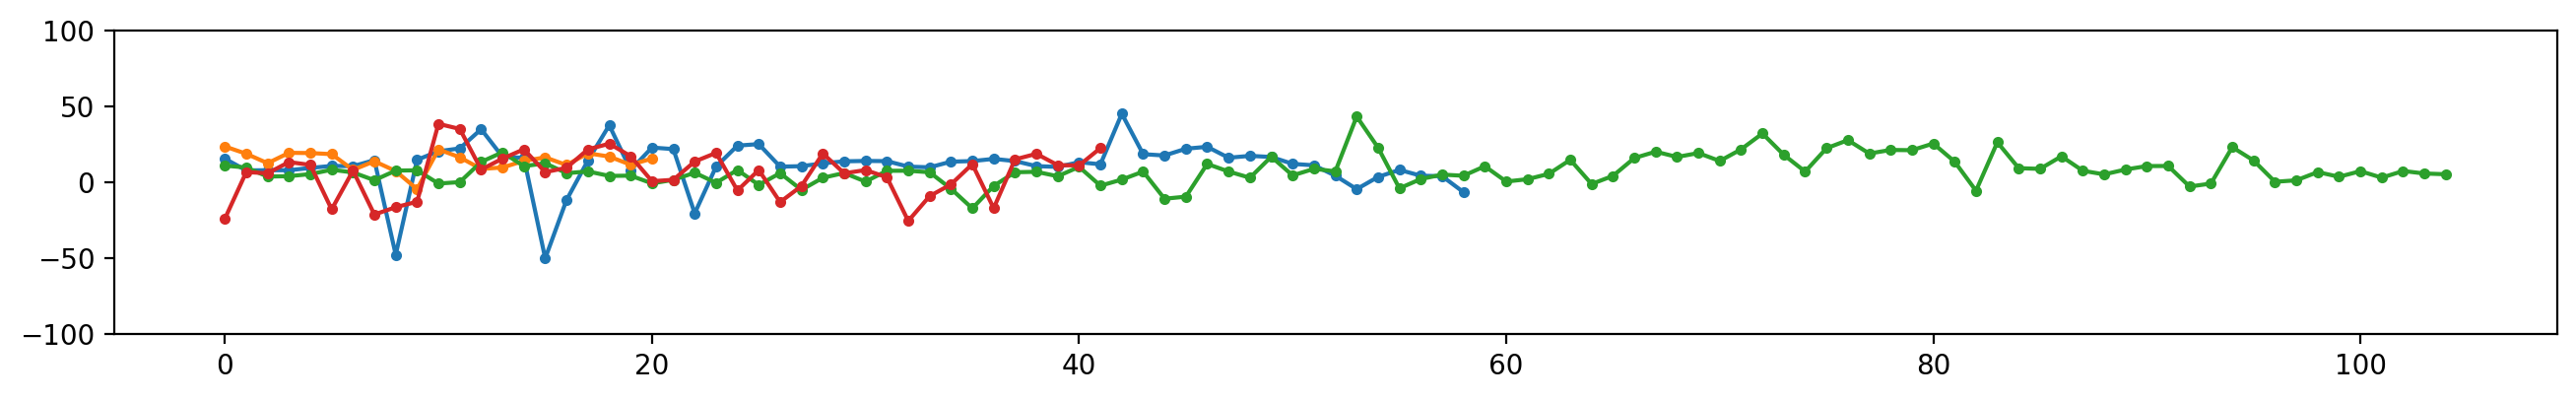

In [122]:
# 8, 9, 12, 13, 14, 15, 23, 27
plt.figure(figsize=[16, 2], dpi=200)
pcode = 67
for s in range(0, int(ds.stage.max().values)+1):
    diff = ds.where((ds.pcode==pcode) & (ds.stage==s), drop=True).hlc - ds.where((ds.pcode==pcode) & (ds.stage==s), drop=True).hlb
    if len(diff.values) > 20:
        plt.plot(diff.values, '.-')
        print(np.mean(diff.values))
plt.ylim([-100, 100])

-0.007088223094831417
0.018270384560002337
0.002828412825905163
0.0005606811052929858
0.009022118894665487
0.01787145278223154
0.010286223233011663
-0.0019164309102899567
0.02077547840774044
0.053766260837644096
0.0288826932246596
0.011492898801215165
-0.007478808282723016
0.010768638321212352
0.013681242748802202
-0.06059213615435852
0.015329447003235592
-0.011207758246359561


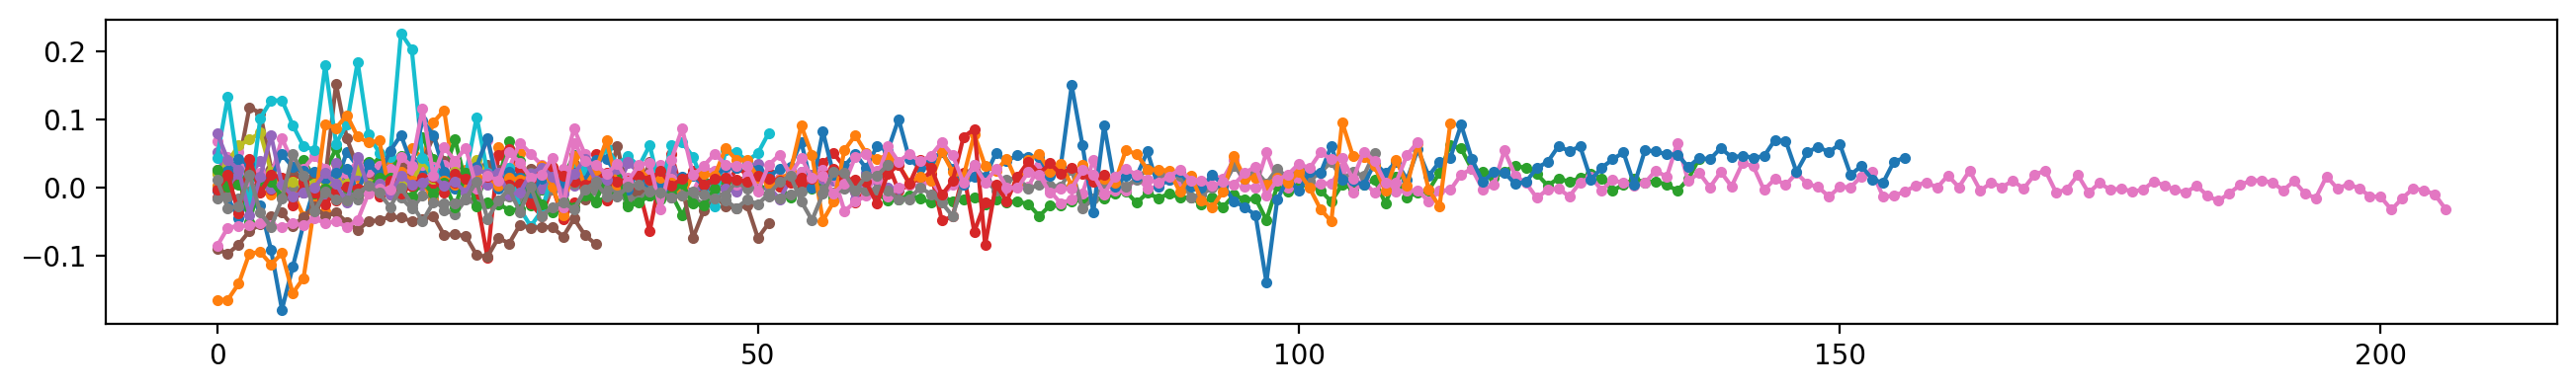

In [74]:
# 8, 9, 12, 13, 14, 15, 23, 27
plt.figure(figsize=[16, 2], dpi=200)
pcode = 69
for s in range(0,46):
    diff = ds.where((ds.pcode==pcode) & (ds.stage==s), drop=True).taucx - ds.where((ds.pcode==pcode) & (ds.stage==s), drop=True).taubx
    if len(diff.values) > 20:
        plt.plot(diff.values, '.-')
        print(np.mean(diff.values))
# plt.ylim([-100, 100])

In [ ]:
plt.plot(ds.where((ds.pcode==67))

In [12]:
ds

<xarray.Dataset>
Dimensions:  (time: 1610)
Coordinates:
  * time     (time) datetime64[ns] 1999-11-02T03:24:59.040000 ... 2004-11-27T...
Data variables: (12/24)
    taucx    (time) float64 0.06388 0.0248 -0.0222 ... 0.03608 0.06174 0.05714
    taucy    (time) float64 -0.0161 -0.03092 -0.02793 ... -0.02406 -0.02318
    hsc      (time) float64 -7.07 -10.81 -2.403 -3.897 ... -4.772 -6.101 -5.134
    hlc      (time) float64 -59.62 -49.06 -45.95 -22.81 ... -52.96 -107.2 -99.52
    U        (time) float64 6.897 5.43 4.287 4.123 ... 5.238 6.094 6.643 6.276
    tsea     (time) float64 12.74 11.91 9.735 9.216 ... 19.56 19.57 19.94 19.84
    ...       ...
    hsb      (time) float64 -45.75 -36.71 -12.36 -8.662 ... -1.488 -2.801 -1.772
    taubx    (time) float64 0.06806 0.04016 0.02286 ... 0.04268 0.05237 0.04568
    tauby    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    tdiff    (time) float64 4.294 4.03 1.862 1.424 ... 0.3165 0.4481 0.345
    weight   (time) float64 0.1689 0.07279 0.2618 ... 0.09359 0.1126 0.09765
    stage    (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 44.0 45.0 45.0 46.0 46.0
Attributes:
    bulkalg:  coare3p6
    weight:   1
    wave:     0